### Experiment 1

Two nodes system. In this experiment two nodes are connected (feedforward), and in each trial a stimulus of different amplitude is applied to phase and amplitude in the node sending the connection.

Here we can measure the unique information between the amplitude products and stimuli as well as phase and stimuli (either on the time or time-frequency domain), as a function of a and beta. In the heterogeneous case, instead of using a as a control parameter we might use the difference between this parameter in the sender vs. the receiver node. The same can be done if the nodes have distinct oscillating frequencies.

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/Documentos/StuartLandauWBM/")

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc
from hoi.core import get_mi
from plot import circular_hist
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [4]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def return_unique_terms(data, stim, shuffle=False):

    x = data.sel(roi="x") * np.conj(data.sel(roi="y"))

    if shuffle:
        x = shuffle_along_axis(x.data, 0)

    R1 = np.asarray((x * np.conj(x)).real)
    R2 = np.unwrap(np.angle(x))

    # Stims across trials
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (data.sizes["times"], 1)).squeeze().T

    I_S_12 = gccmi_nd_ccc(R1, R2, stim, traxis=0)
    I_S_1 = gcmi_nd_cc(stim, R1, traxis=0)
    I_S_2 = gcmi_nd_cc(stim, R2, traxis=0)
    R_12 = np.minimum(I_S_1, I_S_2)

    if shuffle:
        return np.maximum(I_S_1, I_S_2)
    return I_S_1 - R_12, I_S_2 - R_12

#### Simulation (no-delays) 

In [5]:
ntrials = 500
fsamp = 1 / 1e-4

time = np.arange(-1, 3, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 15

C = np.array([[0, 1], [0, 0]]).T

f = 40

g = 10

In [6]:
simulate_jax = jax.vmap(
    simulate,
    in_axes=(None, None, None, None, None, None, None, None, 0, 0, 0, None, None, None),
)

In [7]:
a = jnp.array([-5, -5])
f = jnp.array([40, 40])

In [8]:
Iext = np.zeros((2, Npoints))
Iext[:1, (time >= 0) & (time <= 0.2)] = 1
Amplitudes = np.linspace(0, 1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

# Stimulus to amplitude

data_amp = np.stack(
    simulate_jax(
        C,
        g,
        g,
        f,
        a,
        fsamp,
        beta,
        Npoints,
        CS * 1e-3,
        CS * 0,
        seeds,
        "hopf",
        "cpu",
        decim,
    )
)
data_amp = data_amp.squeeze()

# Stimulus to phase
data_phase = np.stack(
    simulate_jax(
        C,
        g,
        g,
        f,
        a,
        fsamp,
        beta,
        Npoints,
        CS * 0,
        CS * np.pi * 60,
        seeds,
        "hopf",
        "cpu",
        decim,
    )
)
data_phase = data_phase.squeeze()

# Stimulus to amplitude and phase

data_both = np.stack(
    simulate_jax(
        C,
        g,
        g,
        f,
        a,
        fsamp,
        beta,
        Npoints,
        CS * 1e-3,
        CS * np.pi * 60,
        seeds,
        "hopf",
        "cpu",
        decim,
    )
)
data_both = data_both.squeeze()

In [9]:
data_amp = xr.DataArray(
    data_amp,
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, ["x", "y"], time[::decim]),
)

data_phase = xr.DataArray(
    data_phase,
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, ["x", "y"], time[::decim]),
)

data_both = xr.DataArray(
    data_both,
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, ["x", "y"], time[::decim]),
)

In [10]:
_topi = lambda x: (x + np.pi) % (2 * np.pi) - np.pi

In [11]:
uamp1, uphase1 = return_unique_terms(data_amp, Amplitudes)
uamp2, uphase2 = return_unique_terms(data_phase, Amplitudes)
uamp3, uphase3 = return_unique_terms(data_both, Amplitudes)

__iter = tqdm(range(50))
uc1 = [return_unique_terms(data_amp, Amplitudes, True) for i in __iter]
uc2 = [return_unique_terms(data_phase, Amplitudes, True) for i in __iter]
uc3 = [return_unique_terms(data_both, Amplitudes, True) for i in __iter]

100%|████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


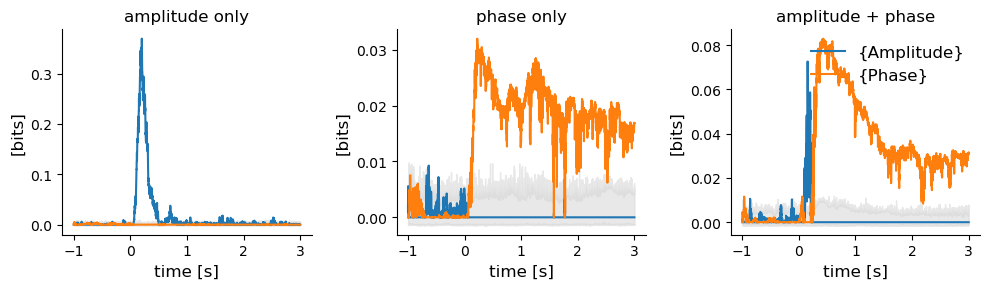

In [12]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(131)

plt.plot(time[::decim], uamp1)
plt.plot(time[::decim], uphase1)
plt.fill_between(
    time[::decim],
    np.quantile(uc1, 0.05, axis=0),
    np.quantile(uc1, 0.95, axis=0),
    color="lightgray",
    alpha=0.5,
)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)
plt.title("amplitude only", fontsize=12)

ax = plt.subplot(132)

plt.plot(time[::decim], uamp2)
plt.plot(time[::decim], uphase2)
plt.fill_between(
    time[::decim],
    np.quantile(uc2, 0.05, axis=0),
    np.quantile(uc2, 0.95, axis=0),
    color="lightgray",
    alpha=0.5,
)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)
plt.title("phase only", fontsize=12)

ax = plt.subplot(133)

plt.plot(time[::decim], uamp3)
plt.plot(time[::decim], uphase3)
plt.fill_between(
    time[::decim],
    np.quantile(uc3, 0.05, axis=0),
    np.quantile(uc3, 0.95, axis=0),
    color="lightgray",
    alpha=0.5,
)
plt.legend(
    ["{Amplitude}", "{Phase}"],
    fontsize=12,
    frameon=False,
)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)
plt.title("amplitude + phase", fontsize=12)


plt.tight_layout()

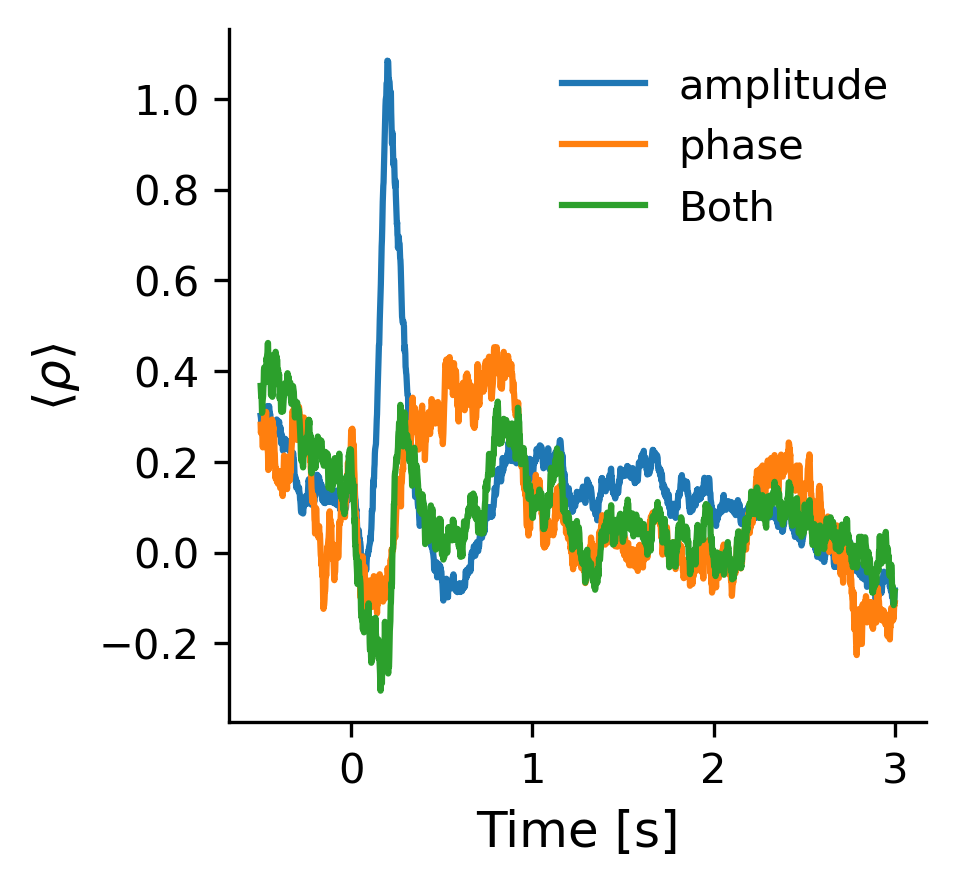

In [13]:
plt.figure(figsize=(3, 3), dpi=300)

data = [data_amp, data_phase, data_both]
ax = plt.subplot(111)
for pos, data_ in enumerate(data):

    r = np.abs(data_)

    r = (r - r.mean("times")) / r.std("times")

    z = np.angle(data_[:, 0] * np.conj(data_[:, 1]))
    theta = xr.DataArray(
        z, dims=("trials", "times"), coords={"times": data_.times.values}
    ).mean("trials")

    (r[:, 0] * r[:, 1]).sel(times=slice(-0.5, 3)).mean("trials").plot()
    # ax2 = ax.twinx()
    #(theta).sel(times=slice(-.5, 3)).plot()
    plt.ylabel(r"$\langle\rho \rangle$", fontsize=12)
    plt.xlabel("Time [s]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.legend(["amplitude", "phase", "Both"], frameon=False)

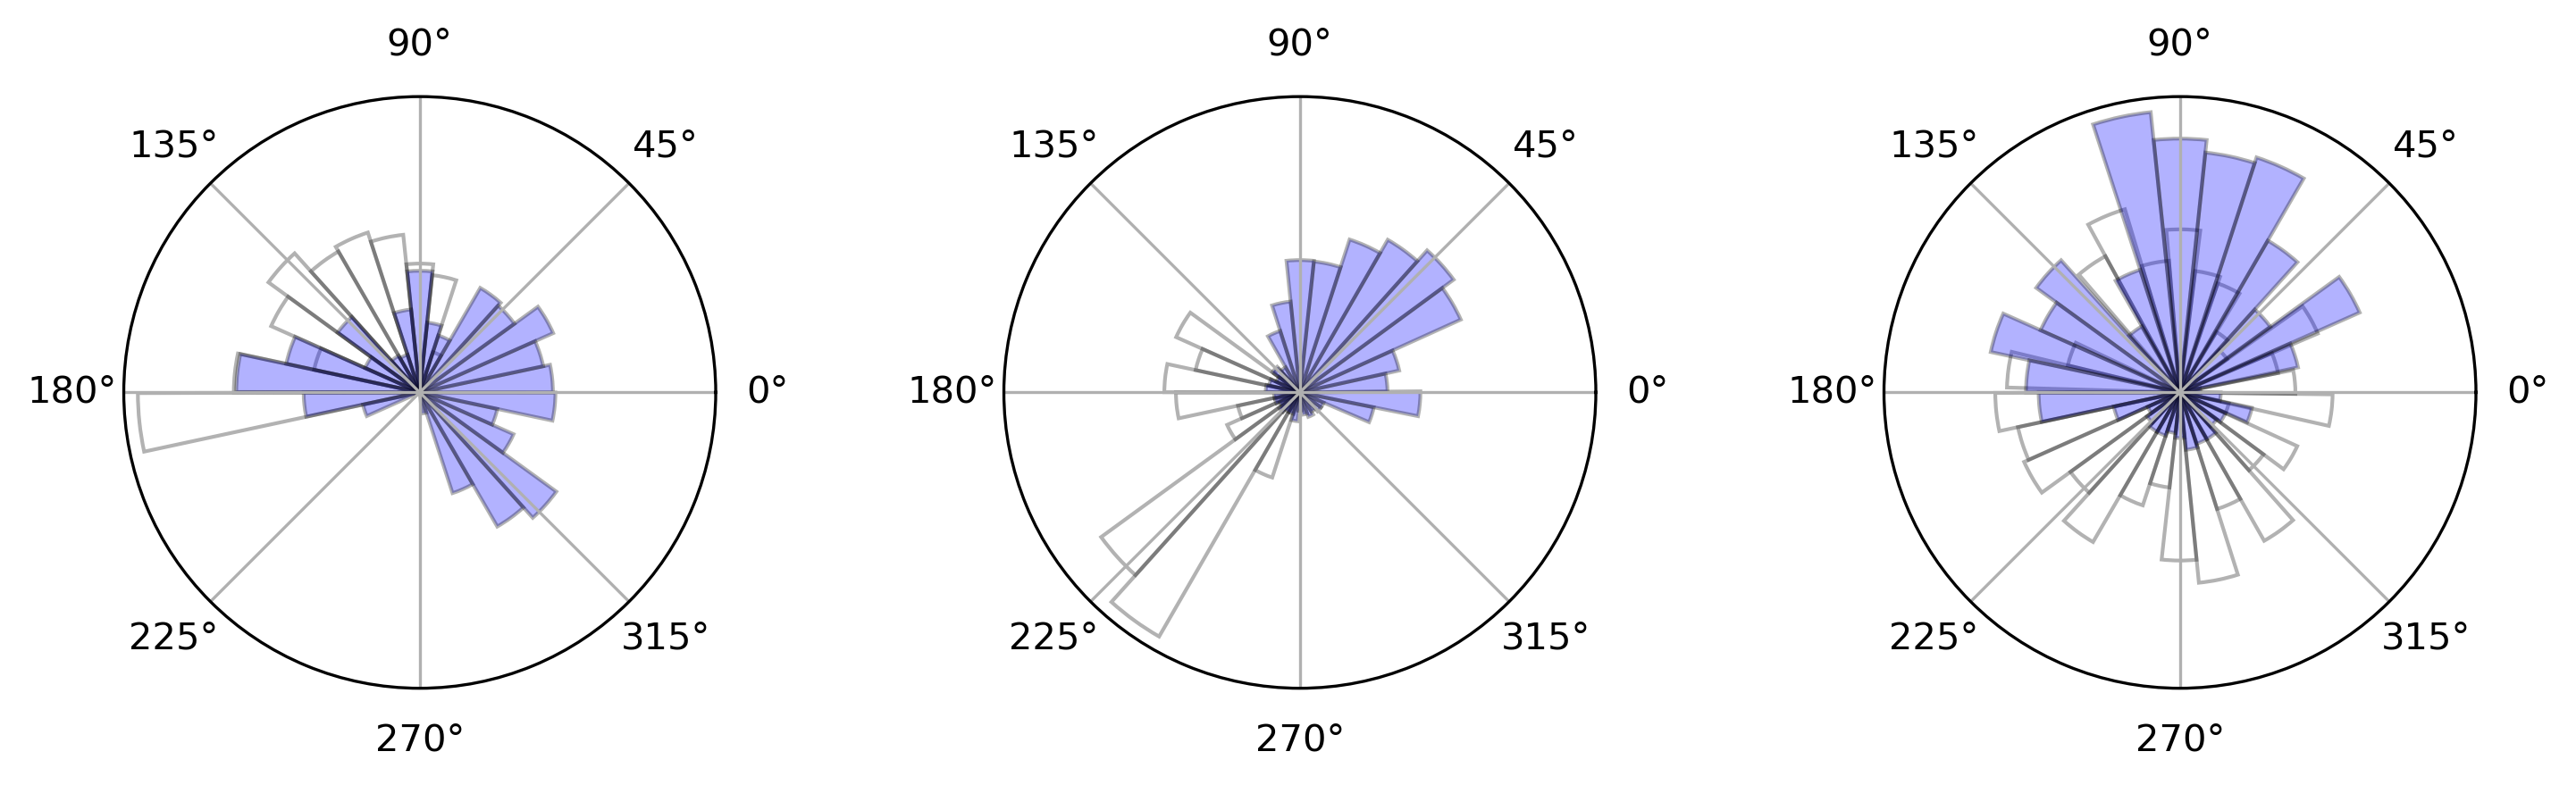

In [15]:
plt.figure(figsize=(10, 3), dpi=300)

data = [data_amp, data_phase, data_both]

for pos, data_ in enumerate(data):
    ax = plt.subplot(1, 3, pos + 1, projection="polar")
    z = np.unwrap(np.angle(data_[:, 0] * np.conj(data_[:, 1])))
    theta = xr.DataArray(
        z, dims=("trials", "times"), coords={"times": data_.times.values}
    ).mean("trials")
    circular_hist(ax, theta.sel(times=slice(-2, 0)).data, fill=False, bins=30)
    circular_hist(ax, theta.sel(times=slice(0, 2)).data, fill=True, bins=30)
# [ax.spines[key].set_visible(False) for key in ["top", "right"]]
# plt.legend(["amplitude", "phase", "Both"], frameon=False)
plt.tight_layout()